Matrix Factorization for Recommender Systems 
--------------
simplified article by Kat Hailey -- very good and short explanation

http://katbailey.github.io/post/matrix-factorization-with-tensorflow/

My remarks: 
- need to scale the data for each user - instead of real views use percentage of total views by that user
- this has a problem (maybe not so much as a method, but the optimization approach) - the optimization can get stuck in something called Nash equilibria (?) see comments to the article, recommended solution is stochastic gradient descent ? or perhaps use another optimizer than vanilla gd (adam ?) 

Configurable parameters 
- rank (number of features to learn)
- lambda (regularization parameter)
- learning rate in optimization (gradient descent)

In [82]:
import tensorflow as tf
import numpy as np

** Specify parameters and dimensions **

In [83]:
num_users = 128
num_items = 1024   
rank = 16          ## number of learned features
lda = .01          ## weight of regularization 
lr = 1.0           ## learning rate
max_iter = 10000   ## number of iterations in optimization 

** Provide data **

In [73]:
## I will just generate some -- first pick random users (they can repeat)
## then randomly pick vector of items of the same length 
avg_items_per_user = 5
data_len = avg_items_per_user * num_users

user_indices = np.random.randint(0, num_users, size = data_len)
item_indices = np.random.randint(0, num_items, size = data_len)
rating_values = np.ones(data_len)
num_ratings = np.sum(rating_values) ## number of ratings, in our case sum of number of users that va

** Specify Tensorflow model **

In [74]:
# Initialize the matrix factors from random normals with mean 0. W will
# represent users and H will represent items.
W = tf.Variable(tf.truncated_normal([num_users, rank], stddev=0.2, mean=0), name="users")
H = tf.Variable(tf.truncated_normal([rank, num_items], stddev=0.2, mean=0), name="items")

result = tf.matmul(W, H)

# Now we just want the values represented by the pairs of user and item
# indices for which we had known ratings. 
indices = tf.stack([user_indices, item_indices], axis=1)
result_values = tf.gather_nd(result, indices, name='predicted_rating')

# Calculate the difference between the predicted ratings and the actual
# ratings. The predicted ratings are the values obtained form the matrix
# multiplication with the mean rating added on.
diff_op = tf.sub(result_values, rating_values, name="raw_training_error")

base_cost = tf.reduce_sum(tf.square(diff_op, name="squared_difference"), name="sum_squared_error")
# Add regularization.
regularizer = tf.mul(tf.add(tf.reduce_sum(tf.square(W)), tf.reduce_sum(tf.square(H))), lda, name="regularize")
cost = tf.div(tf.add(base_cost, regularizer), num_ratings * 2, name="average_error")

# Use an exponentially decaying learning rate.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step, 10000, 0.96, staircase=True)


optimizer = tf.train.GradientDescentOptimizer(learning_rate)
# Passing global_step to minimize() will increment it at each step so
# that the learning rate will be decayed at the specified intervals.
train_step = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()


** Run the optimizer **

In [75]:
sess = tf.Session()
sess.run(init)

for i in range(max_iter):
    if i % 500 == 0:
        cost_r, base_cost_r, regularizer_r = sess.run([cost * num_ratings * 2, base_cost, regularizer])
        print("Cost at",i,"th iteration was: ", cost_r, "  base cost: ", base_cost_r, "  regul.: ", regularizer_r)
    else:
        sess.run(train_step)
        
final_res, final_W, final_H = sess.run([result, W, H])

Cost at 0 th iteration was:  662.347   base cost:  656.674   regul.:  5.67238
Cost at 500 th iteration was:  39.506   base cost:  30.7492   regul.:  8.75687
Cost at 1000 th iteration was:  10.0151   base cost:  0.384337   regul.:  9.63076
Cost at 1500 th iteration was:  9.64695   base cost:  0.0269028   regul.:  9.62004
Cost at 2000 th iteration was:  9.56879   base cost:  0.0126907   regul.:  9.5561
Cost at 2500 th iteration was:  9.49991   base cost:  0.0114217   regul.:  9.48849
Cost at 3000 th iteration was:  9.43261   base cost:  0.0112479   regul.:  9.42136
Cost at 3500 th iteration was:  9.36643   base cost:  0.0112232   regul.:  9.35521
Cost at 4000 th iteration was:  9.30132   base cost:  0.0112258   regul.:  9.29009
Cost at 4500 th iteration was:  9.23724   base cost:  0.0112354   regul.:  9.226
Cost at 5000 th iteration was:  9.17419   base cost:  0.0112464   regul.:  9.16294
Cost at 5500 th iteration was:  9.11214   base cost:  0.0112557   regul.:  9.10089
Cost at 6000 th i

Show results
-------

In [76]:
import matplotlib.pyplot as plt

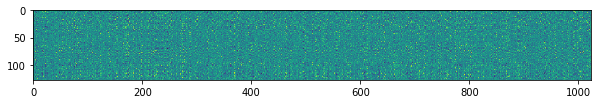

In [81]:
plt.figure(figsize = (10,5))
plt.imshow(final_res)
plt.show()